## グラフDB（Amazon Neptune）のステータスをチェック

In [496]:
%status

{
  "status": "healthy",
  "startTime": "Fri Jan 24 02:21:15 UTC 2020",
  "dbEngineVersion": "1.0.2.1.R4",
  "role": "writer",
  "gremlin": {
    "version": "tinkerpop-3.4.1"
  },
  "sparql": {
    "version": "sparql-1.1"
  },
  "labMode": {
    "ObjectIndex": "disabled",
    "Streams": "disabled",
    "ReadWriteConflictDetection": "enabled"
  }
}


## 保険契約データからソーシャルグラフの関係性を抽出

In [431]:
import pandas as pd

In [432]:
df_branch = pd.read_csv('data/branch_info.csv')
df_staff = pd.read_csv('data/generated_staffs.csv')
df_contract = pd.read_csv('data/generated_contracts.csv')

In [433]:
df_branch.head(3)

,postal_area,post_office_cd,post_office_name,post_office_pronunciation
0,神田,1008,神田郵便局,かんだ
1,神田,1024,小川町駅前郵便局,おがわまちえきまえ
2,神田,1042,西神田郵便局,にしかんだ


In [434]:
df_staff.head(3)

,staff_cd,last_name,first_name,last_name_pronunciation,first_name_pronunciation,gender,birthday,age,phone,post_office_cd
0,0,柳,昭一,ヤナギ,ショウイチ,男,1985/9/25,34,090-3602-0717,755
1,1,栗原,昌之,クリハラ,マサユキ,男,1985/8/29,34,090-2226-4253,1128
2,2,戸川,心愛,トガワ,ココア,女,1969/10/21,50,080-8104-8561,1072


In [435]:
df_contract.head(3)

,staff_cd,type,contractor_last_name,contractor_last_name_pron,contractor_first_name,contractor_first_name_pron,contractor_age,contractor_birthday,contractor_gender,contractor_postal_cd,...,insured_first_name,insured_first_name_pron,insured_age,insured_birthday,insured_gender,insured_postal_cd,insured_address_1,insured_address_2,insured_address_3,insured_phone
0,17,定期,江崎,エサキ,実桜,ミオ,15,2004/8/25,女,170-8457,...,実桜,ミオ,15,2004/8/25,女,170-8457,東京都,豊島区,南大塚２丁目２９番７号,090-8967-9720
1,17,養老,江崎,エサキ,実桜,ミオ,15,2004/8/25,女,170-8457,...,実桜,ミオ,15,2004/8/25,女,170-8457,東京都,豊島区,南大塚２丁目２９番７号,090-8967-9720
2,17,学資,江崎,エサキ,実桜,ミオ,15,2004/8/25,女,170-8457,...,裕子,ヒロコ,0,1987/3/24,女,170-8457,東京都,豊島区,南大塚２丁目２９番７号,080-6117-0321


In [436]:
post_office_cds = [str(x) for x in df_staff.post_office_cd.unique().tolist()]
df_target_branch = df_branch[df_branch.post_office_cd.isin(post_office_cds)]
df_target_branch

,postal_area,post_office_cd,post_office_name,post_office_pronunciation
4,神田,1128,神田今川橋郵便局,かんだいまがわばし
29,銀座,1072,東京高等裁判所内郵便局,とうきょうこうとうさいばんしょない
46,銀座,755,千代田霞が関郵便局,ちよだかすみがせき


### 郵便局ノードを生成

In [437]:
num_post_office = df_target_branch.shape[0]

ids = ['po{}'.format(x) for x in df_target_branch.post_office_cd.tolist()]
names = [x for x in df_target_branch.post_office_name.tolist()]

df_node_postoffice = pd.DataFrame({'~id': ids, 'name:String': names, '~label': 'post_office'})
df_node_postoffice.to_csv('data/node1.csv', index=False, encoding='utf-8')

In [438]:
df_node_postoffice

,~id,name:String,~label
0,po1128,神田今川橋郵便局,post_office
1,po1072,東京高等裁判所内郵便局,post_office
2,po755,千代田霞が関郵便局,post_office


### 社員ノードを生成

In [439]:
df_staff.head(3)

,staff_cd,last_name,first_name,last_name_pronunciation,first_name_pronunciation,gender,birthday,age,phone,post_office_cd
0,0,柳,昭一,ヤナギ,ショウイチ,男,1985/9/25,34,090-3602-0717,755
1,1,栗原,昌之,クリハラ,マサユキ,男,1985/8/29,34,090-2226-4253,1128
2,2,戸川,心愛,トガワ,ココア,女,1969/10/21,50,080-8104-8561,1072


In [440]:
num_staffs = df_staff.shape[0]
df_staff['name'] = df_staff['last_name'] + df_staff['first_name']

ids = ['s{}'.format(x) for x in df_staff.staff_cd.tolist()]
names = [x for x in df_staff.name.tolist()]
ages = [x for x in df_staff.age.tolist()]
genders = [x for x in df_staff.gender.tolist()]

df_node_staff = pd.DataFrame({'~id': ids, 'name:String': names, 'age:Int': ages, 'gender:String': genders, '~label': 'staff'})
df_node_staff.to_csv('data/node2.csv', index=False, encoding='utf-8')

In [441]:
df_node_staff.head(3)

,~id,name:String,age:Int,gender:String,~label
0,s0,柳昭一,34,男,staff
1,s1,栗原昌之,34,男,staff
2,s2,戸川心愛,50,女,staff


### 郵便局->社員のエッジを生成

In [461]:
# エッジを生成
edge_ids = ['po_s{}'.format(x) for x in range(0, num_staffs)]
from_nodes = ['po{}'.format(x) for x in df_staff.post_office_cd.tolist()]
to_nodes = ['s{}'.format(x) for x in df_staff.staff_cd.tolist()]

df_edge = pd.DataFrame({'~id': edge_ids, '~from': from_nodes, '~to': to_nodes, '~label': 'branch_staff'})
df_edge.to_csv('data/edge1.csv', index=False)

In [462]:
df_edge.head(3)

,~id,~from,~to,~label
0,po_s0,po755,s0,branch_staff
1,po_s1,po1128,s1,branch_staff
2,po_s2,po1072,s2,branch_staff


In [463]:
df_node_postoffice

,~id,name:String,~label
0,po1128,神田今川橋郵便局,post_office
1,po1072,東京高等裁判所内郵便局,post_office
2,po755,千代田霞が関郵便局,post_office


### 契約者ノードを生成

In [464]:
contractor_columns = ['contractor_last_name',
                      'contractor_last_name_pron',
                      'contractor_first_name',
                      'contractor_first_name_pron',
                      'contractor_age',
                      'contractor_birthday',
                      'contractor_gender',
                      'contractor_postal_cd',
                      'contractor_address_1',
                      'contractor_address_2',
                      'contractor_address_3',
                      'contractor_phone']
contractor_unique_cols = ['contractor_last_name',
                      'contractor_first_name',
                      'contractor_birthday',
                      'contractor_address_1',
                      'contractor_address_2',
                      'contractor_address_3']

In [465]:
# 保険契約者の名寄せを実行
df_unique_contractor = df_contract[contractor_columns].copy()
df_unique_contractor = df_unique_contractor.groupby(by=contractor_unique_cols).max()
df_unique_contractor['contractor_id'] = ['c{}'.format(x) for x in range(0, df_unique_contractor.shape[0])]
df_unique_contractor.reset_index(inplace=True)

In [482]:
# 保険契約者のノードを生成
df_unique_contractor['contractor_name'] = df_unique_contractor['contractor_last_name'] + df_unique_contractor['contractor_first_name']

ids = [x for x in df_unique_contractor.contractor_id.tolist()]
names = [x for x in df_unique_contractor.contractor_name.tolist()]
ages = [x for x in df_unique_contractor.contractor_age.tolist()]
genders = [x for x in df_unique_contractor.contractor_gender.tolist()]

df_node_contractor = pd.DataFrame({'~id': ids, 'name:String': names, 'age:Int': ages, 'gender:String': genders, '~label': '契約者'})

### 被保険者ノードを生成

In [483]:
insured_columns = ['insured_last_name',
                      'insured_last_name_pron',
                      'insured_first_name',
                      'insured_first_name_pron',
                      'insured_age',
                      'insured_birthday',
                      'insured_gender',
                      'insured_postal_cd',
                      'insured_address_1',
                      'insured_address_2',
                      'insured_address_3',
                      'insured_phone']
insured_unique_cols = ['insured_last_name',
                      'insured_first_name',
                      'insured_birthday',
                      'insured_address_1',
                      'insured_address_2',
                      'insured_address_3']

In [484]:
# 被保険者の名寄せを実行
df_unique_insured = df_contract[insured_columns].copy()
df_unique_insured = df_unique_insured.groupby(by=insured_unique_cols).max()
df_unique_insured['insured_id'] = ['i{}'.format(x) for x in range(0, df_unique_insured.shape[0])]
df_unique_insured.reset_index(inplace=True)

In [485]:
# 保険契約者のノードを生成
df_unique_insured['insured_name'] = df_unique_insured['insured_last_name'] + df_unique_insured['insured_first_name']

ids = [x for x in df_unique_insured.insured_id.tolist()]
names = [x for x in df_unique_insured.insured_name.tolist()]
ages = [x for x in df_unique_insured.insured_age.tolist()]
genders = [x for x in df_unique_insured.insured_gender.tolist()]

df_node_insured = pd.DataFrame({'~id': ids, 'name:String': names, 'age:Int': ages, 'gender:String': genders, '~label': '被保険者'})

In [486]:
# ロード用ファイルとして出力
df_node_out = pd.concat([df_node_contractor, df_node_insured])
df_node_out.to_csv('data/node3.csv', index=False, encoding='utf-8')

### 社員->契約者エッジを生成

In [487]:
# 社員と契約者（のべ）の対応表を生成
df_staff_contractor = pd.merge(df_contract, df_unique_contractor, how='left', on=contractor_unique_cols)
df_staff_contractor = df_staff_contractor[['staff_cd', 'contractor_id', 'type']].copy()

In [488]:
# エッジを生成
edge_ids = ['s_c{}'.format(x) for x in df_staff_contractor.index.tolist()]
from_nodes = ['s{}'.format(x) for x in df_staff_contractor.staff_cd.tolist()]
to_nodes = [x for x in df_staff_contractor.contractor_id.tolist()]
labels = ['契約：{}'.format(x) for x in df_staff_contractor.type.tolist()]

df_sc_edge = pd.DataFrame({'~id': edge_ids, '~from': from_nodes, '~to': to_nodes, '~label': labels})
df_sc_edge.to_csv('data/edge2.csv', index=False)

### 契約者->被保険者エッジを生成

In [489]:
# 契約者と被保険者の対応表を生成
df_temp = pd.merge(df_contract, df_staff_contractor.contractor_id, how='inner', left_index=True, right_index=True)
df_contractor_insured = pd.merge(df_temp, df_unique_insured, how='left', on=insured_unique_cols)

In [490]:
def detect_relation(row):
    if (row.contractor_last_name == row.insured_last_name) and (row.contractor_first_name == row.insured_first_name):
        return '被保険：本人'
    elif (row.contractor_last_name == row.insured_last_name) and (row.contractor_first_name != row.insured_first_name):
        return '被保険：家族'
    else:
        return '被保険：第3者'
        
detect_relation(df_contractor_insured.iloc[1])

'被保険：本人'

In [491]:
# エッジを生成
edge_ids = ['c_i{}'.format(x) for x in df_contractor_insured.index.tolist()]
from_nodes = [x for x in df_contractor_insured.contractor_id.tolist()]
to_nodes = [x for x in df_contractor_insured.insured_id.tolist()]
labels = df_contractor_insured.apply(detect_relation, axis=1).tolist()

df_ci_edge = pd.DataFrame({'~id': edge_ids, '~from': from_nodes, '~to': to_nodes, '~label': labels})
df_ci_edge.to_csv('data/edge3.csv', index=False)

### 生成したノードとエッジの情報をS3にコピー

In [1]:
!aws s3 cp 'data/node1.csv' 's3://<s3-bucket-name>/data/graph/'
!aws s3 cp 'data/node2.csv' 's3://<s3-bucket-name>/data/graph/'
!aws s3 cp 'data/node3.csv' 's3://<s3-bucket-name>/data/graph/'
!aws s3 cp 'data/edge1.csv' 's3://<s3-bucket-name>/data/graph/'
!aws s3 cp 'data/edge2.csv' 's3://<s3-bucket-name>/data/graph/'
!aws s3 cp 'data/edge3.csv' 's3://<s3-bucket-name>/data/graph/'

upload: data/node1.csv to s3://tuki-bkt-misc/data/graph/node1.csv 


### curlコマンドを利用してRESTでロード処理を起動

load実行前に既存のグラフを削除する

In [493]:
%%gremlin

g.V().drop()

Console 
 
 

 
 
 
 
 
 
 

 
 
 
 
 
 Page Size: 
 
 Total Results: 0

In [494]:
%%gremlin

g.V().count()

1,0


In [ ]:
!curl -X POST \
    -H 'Content-Type: application/json' \
    https://<neptune-instance-url>.ap-northeast-1.neptune.amazonaws.com:8182/loader -d ' \
    { \
      "source" : "s3://<s3-bucket-name>/data/graph", \
      "format" : "csv", \
      "iamRoleArn" : "<put arn here>", \
      "region" : "ap-northeast-1", \
      "failOnError" : "FALSE", \
      "parallelism" : "MEDIUM", \
      "updateSingleCardinalityProperties" : "FALSE" \
    }' \



### ロードコマンドが返却したloadIdを利用してステータスを照会

In [ ]:
!curl -X GET 'https://<neptune-instance-url>.ap-northeast-1.neptune.amazonaws.com:8182/loader/<loadid>?details=true&errors=true'


### コマンドやプログラムからグラフにアクセスする

In [70]:
%%gremlin

g.V().drop()

Console 
 
 

 
 
 
 
 
 
 

 
 
 
 
 
 Page Size: 
 
 Total Results: 0

In [ ]:
%%gremlin

In [17]:
%%gremlin

g.V().hasLabel('post_office').valueMap()

1,{'name': ['神田駅前郵便局']}
2,{'name': ['東京中央郵便局']}
3,{'name': ['帝国ホテル内郵便局']}


In [18]:
%%gremlin

g.V().valueMap()

1,"{'gender': ['女'], 'name': ['高垣愛香'], 'age': [31]}"
2,"{'gender': ['男'], 'name': ['西谷一憲'], 'age': [49]}"
3,"{'gender': ['女'], 'name': ['田口陽花'], 'age': [51]}"
4,"{'gender': ['女'], 'name': ['深川智恵理'], 'age': [35]}"
5,"{'gender': ['女'], 'name': ['瓜生奏音'], 'age': [51]}"
6,"{'gender': ['女'], 'name': ['河口友菜'], 'age': [52]}"
7,"{'gender': ['女'], 'name': ['佐久間麻世'], 'age': [38]}"
8,"{'gender': ['女'], 'name': ['松山七美'], 'age': [37]}"
9,"{'gender': ['男'], 'name': ['古谷理'], 'age': [50]}"
10,"{'gender': ['女'], 'name': ['田川香苗'], 'age': [43]}"
11,"{'gender': ['男'], 'name': ['藤澤政男'], 'age': [55]}"


In [19]:
%%gremlin

g.V().hasLabel('post_office').outE().groupCount().by(label())

1,{'branch_staff': 20}


In [20]:
%%gremlin

g.E().hasLabel('branch_staff').bothV()

1,v[post_office329]
2,v[post_office1016]
3,v[post_office329]
4,v[post_office329]
5,v[post_office329]
6,v[post_office1110]
7,v[post_office329]
8,v[post_office1110]
9,v[post_office1016]
10,v[post_office1016]
11,v[post_office329]


In [21]:
%%gremlin

g.V().hasLabel('post_office').outE().group().by(label())

1,"{'branch_staff': [e[e4][post_office329-branch_staff->staff4], e[e1][post_office329-branch_staff->staff1], e[e2][post_office329-branch_staff->staff2], e[e5][post_office1110-branch_staff->staff5], e[e3][post_office329-branch_staff->staff3], e[e6][post_office329-branch_staff->staff6], e[e9][post_office1110-branch_staff->staff9], e[e7][post_office1110-branch_staff->staff7], e[e18][post_office1016-branch_staff->staff18], e[e19][post_office1016-branch_staff->staff19], e[e8][post_office329-branch_staff->staff8], e[e11][post_office329-branch_staff->staff11], e[e12][post_office329-branch_staff->staff12], e[e13][post_office1110-branch_staff->staff13], e[e10][post_office1110-branch_staff->staff10], e[e15][post_office329-branch_staff->staff15], e[e14][post_office1016-branch_staff->staff14], e[e17][post_office1110-branch_staff->staff17], e[e16][post_office329-branch_staff->staff16], e[e0][post_office1016-branch_staff->staff0]]}"


In [22]:
%%gremlin

g.V().hasLabel('staff').valueMap()

1,"{'gender': ['女'], 'name': ['高垣愛香'], 'age': [31]}"
2,"{'gender': ['男'], 'name': ['西谷一憲'], 'age': [49]}"
3,"{'gender': ['女'], 'name': ['田口陽花'], 'age': [51]}"
4,"{'gender': ['女'], 'name': ['深川智恵理'], 'age': [35]}"
5,"{'gender': ['女'], 'name': ['瓜生奏音'], 'age': [51]}"
6,"{'gender': ['女'], 'name': ['河口友菜'], 'age': [52]}"
7,"{'gender': ['女'], 'name': ['佐久間麻世'], 'age': [38]}"
8,"{'gender': ['女'], 'name': ['松山七美'], 'age': [37]}"
9,"{'gender': ['男'], 'name': ['古谷理'], 'age': [50]}"
10,"{'gender': ['女'], 'name': ['田川香苗'], 'age': [43]}"
11,"{'gender': ['男'], 'name': ['藤澤政男'], 'age': [55]}"


In [23]:
%%gremlin

g.V().hasLabel('staff').has('gender', '女').outE()

Console 
 
 

 
 
 
 
 
 
 

 
 
 
 
 
 Page Size: 
 
 Total Results: 0

In [24]:
!pip install gremlin_python

  Could not find a version that satisfies the requirement gremlin_python (from versions: )
No matching distribution found for gremlin_python
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

graph = Graph()

remoteConn = DriverRemoteConnection('ws://test1.cffve86vy80c.ap-northeast-1.neptune.amazonaws.com:8182/gremlin','g')
g = graph.traversal().withRemote(remoteConn)

In [26]:
print(g.V().hasLabel('post_office').toList())

[v[post_office329], v[post_office1016], v[post_office1110]]


In [27]:
post_offices = g.V().hasLabel('post_office').toList()

In [28]:
g.V(post_offices[1]).outE().toList()

[e[e0][post_office1016-branch_staff->staff0],
 e[e14][post_office1016-branch_staff->staff14],
 e[e18][post_office1016-branch_staff->staff18],
 e[e19][post_office1016-branch_staff->staff19]]

In [29]:
post_offices = g.V().hasLabel('post_office').toList()

for current_v in post_offices:
    print(current_v)
    print(g.V(current_v).outE().inV().toList())

v[post_office329]
[v[staff1], v[staff2], v[staff3], v[staff4], v[staff6], v[staff8], v[staff11], v[staff12], v[staff15], v[staff16]]
v[post_office1016]
[v[staff0], v[staff14], v[staff18], v[staff19]]
v[post_office1110]
[v[staff5], v[staff7], v[staff9], v[staff10], v[staff13], v[staff17]]


In [30]:
g.V().hasLabel('post_office').values('name').toList()

['神田駅前郵便局', '東京中央郵便局', '帝国ホテル内郵便局']

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


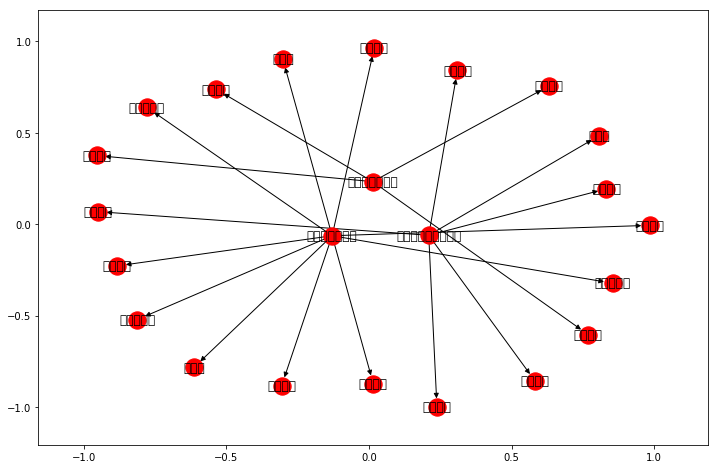

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

# 描画用ネットワークを初期化
G = nx.DiGraph()

post_offices = g.V().hasLabel('post_office').toList()
post_office_names = g.V().hasLabel('post_office').values('name').toList()

for current_v, v_name in zip(post_offices, post_office_names):
    G.add_node(v_name)
    staffs = g.V(current_v).outE().inV().values('name').toList()
    G.add_nodes_from(staffs)
    edge_pairs = [(v_name, x) for x in staffs]
    G.add_edges_from(edge_pairs)
    
    
fig, ax = plt.subplots(figsize=(12,8))
nx.draw_networkx(G, ax=ax, font_family='IPAGothic')

#plt.figure(figsize=(24,8))
plt.show()

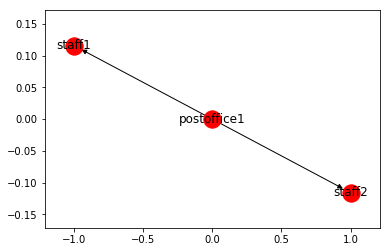

In [32]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx


G = nx.DiGraph()
G.add_node('postoffice1')
G.add_node('staff1')
G.add_node('staff2')
G.add_edge('postoffice1', 'staff1')
G.add_edge('postoffice1', 'staff2')

nx.draw_networkx(G)
plt.show()

In [33]:
g.V(post_offices[1]).outE().inV().toList()

[v[staff0], v[staff14], v[staff18], v[staff19]]

In [24]:
g.V().valueMap().toList()

[{'gender': ['女'], 'name': ['高垣愛香'], 'age': [31]},
 {'gender': ['男'], 'name': ['西谷一憲'], 'age': [49]},
 {'gender': ['女'], 'name': ['田口陽花'], 'age': [51]},
 {'gender': ['女'], 'name': ['深川智恵理'], 'age': [35]},
 {'gender': ['女'], 'name': ['瓜生奏音'], 'age': [51]},
 {'gender': ['女'], 'name': ['河口友菜'], 'age': [52]},
 {'gender': ['女'], 'name': ['佐久間麻世'], 'age': [38]},
 {'gender': ['女'], 'name': ['松山七美'], 'age': [37]},
 {'gender': ['男'], 'name': ['古谷理'], 'age': [50]},
 {'gender': ['女'], 'name': ['田川香苗'], 'age': [43]},
 {'gender': ['男'], 'name': ['藤澤政男'], 'age': [55]},
 {'gender': ['女'], 'name': ['立石美希'], 'age': [35]},
 {'gender': ['女'], 'name': ['小松原芳子'], 'age': [38]},
 {'gender': ['男'], 'name': ['井坂七郎'], 'age': [32]},
 {'gender': ['女'], 'name': ['辰巳佳歩'], 'age': [56]},
 {'gender': ['男'], 'name': ['風間文男'], 'age': [38]},
 {'gender': ['女'], 'name': ['三村晶'], 'age': [34]},
 {'gender': ['女'], 'name': ['河内緑'], 'age': [31]},
 {'gender': ['男'], 'name': ['広瀬重雄'], 'age': [43]},
 {'gender': ['男'], 'name': ['井田

In [28]:
g.V().hasLabel('post_office').group().by('name').toList()

[{'神田駅前郵便局': [v[post_office329]],
  '帝国ホテル内郵便局': [v[post_office1110]],
  '東京中央郵便局': [v[post_office1016]]}]

In [12]:
print(g.V().hasLabel('post_office').toList())

[v[post_office329], v[post_office1016], v[post_office1110]]


In [52]:
import networkx as nx

In [25]:
import gremlin_python
graph = 

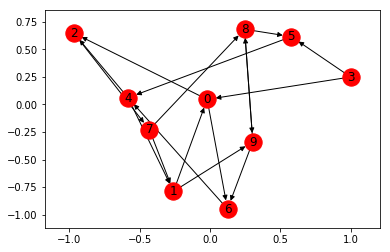

In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx

G = nx.DiGraph()
nx.add_path(G, [3, 5, 4, 1, 0, 2, 7, 8, 9, 6])
nx.add_path(G, [3, 0, 6, 4, 2, 7, 1, 9, 8, 5])

nx.draw_networkx(G)
plt.show()

In [64]:
!pip install networkx -U


    100% |████████████████████████████████| 1.6MB 16.6MB/s ta 0:00:01
Requirement not upgraded as not directly required: decorator>=4.3.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from networkx) (4.3.0)
  Found existing installation: networkx 2.1
    Uninstalling networkx-2.1:
      Successfully uninstalled networkx-2.1
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


'2.1'

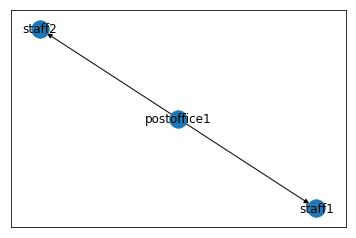

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx


G = nx.DiGraph()
G.add_node('postoffice1')
G.add_node('staff1')
G.add_node('staff2')
G.add_edge('postoffice1', 'staff1')
G.add_edge('postoffice1', 'staff2')

nx.draw_networkx(G)
plt.show()

In [60]:
!conda install python-graphviz --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2u             |       h7b6447c_0         3.1 MB
    ca-certificates-2020.1.1   |                0         132 KB
    python-graphviz-0.13.2     |             py_0          24 KB
    certifi-2019.11.28         |           py36_0         156 KB
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

    python-graphviz: 0.13.2-py_0      

The following packages will be UPDAT

In [61]:
import networkx as nx
from IPython.display import SVG, display

G = nx.DiGraph()
nx.add_path(G, [3, 5, 4, 1, 0, 2, 7, 8, 9, 6])
nx.add_path(G, [3, 0, 6, 4, 2, 7, 1, 9, 8, 5])

svg = SVG(nx.nx_agraph.to_agraph(G).draw(prog='fdp', format='svg'))
display(svg)

ImportError: ('requires pygraphviz ', 'http://pygraphviz.github.io/')